# Evaluation

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install -qqq evaluate==0.4.1
!pip install sentence-transformers
!pip install rouge_score

In [2]:
import evaluate
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
import matplotlib.pyplot as plt

In [3]:
responses_original = pd.read_csv("responses_original.csv")
responses_tuned = pd.read_csv("responses_tuned.csv")

## Evaluation

### Squad V2

https://huggingface.co/spaces/evaluate-metric/squad_v2

In [ ]:
squad_metric = evaluate.load("squad_v2")

In [5]:
def calculate_squad_metric(responses):
  predictions = [{'id': str(i), 'prediction_text': responses["actual"][i], 'no_answer_probability': 0} for i in range(len(responses))]
  references = [{'id': str(i), 'answers': {"answer_start": [0], "text": [responses["correct"][i]]}} for i in range(len(responses))]

  results = squad_metric.compute(predictions=predictions, references=references)
  return results

In [6]:
squad_original = calculate_squad_metric(responses_original)
squad_tuned = calculate_squad_metric(responses_tuned)

print("Original SQUAD Score:")
[print(f"{metric}: {squad_original[metric]}") for metric in squad_original]
f1_original = squad_original["f1"]

print("\nTuned SQUAD Score:")
[print(f"{metric}: {squad_tuned[metric]}") for metric in squad_tuned]
f1_tuned = squad_tuned["f1"]
pass

Original SQUAD Score:
exact: 0.0
f1: 2.6347849929230915
total: 251
HasAns_exact: 0.0
HasAns_f1: 2.6347849929230915
HasAns_total: 251
best_exact: 0.0
best_exact_thresh: 0.0
best_f1: 2.6347849929230915
best_f1_thresh: 0.0

Tuned SQUAD Score:
exact: 0.398406374501992
f1: 7.262526891723157
total: 251
HasAns_exact: 0.398406374501992
HasAns_f1: 7.262526891723157
HasAns_total: 251
best_exact: 0.398406374501992
best_exact_thresh: 0.0
best_f1: 7.262526891723157
best_f1_thresh: 0.0


The SQuAD Score combines multiple useful metrics. An interesting one is the F1 Socre, which works on individual tokens in this case. The tuned model is showing a significant improvement. Both scores are still very low, which is a consequence of the open question answering format.

### Sentence Similarity

https://huggingface.co/tasks/sentence-similarity

Sentence similarity uses a sentence transformer to create embeddings and then calculates the average cosine similarity between the correct and actual responses.

In [ ]:
sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [8]:
def calculate_sentence_similarity(responses):
  similarities = []
  for correct_res, actual_res in zip(responses["correct"], responses["actual"]):
    embedding_1= sentence_transformer.encode(correct_res, convert_to_tensor=True)
    try:
      embedding_2 = sentence_transformer.encode(actual_res, convert_to_tensor=True)
    except TypeError:
      # handle error caused by empty response
      embedding_2 = sentence_transformer.encode(str(actual_res), convert_to_tensor=True)

    similarities.append(util.pytorch_cos_sim(embedding_1, embedding_2).item())

  return np.average(similarities)

In [9]:
sentence_sim_original = calculate_sentence_similarity(responses_original)
sentence_sim_original

0.22812464030875093

In [10]:
sentence_sim_tuned = calculate_sentence_similarity(responses_tuned)
sentence_sim_tuned

0.27446122808879114

### ROUGE Score

https://huggingface.co/spaces/evaluate-metric/rouge

The ROUGE score is a metric desinged to evaluate translations and summaries. Since it compares predictions with ground truths, it can be used for our purposes. We use two of its outputs: The Unigram ROUGE1 Score and the Bigram ROUGE2 Score.

In [ ]:
rouge = evaluate.load('rouge')

In [74]:
def calculate_rouge_score(responses):
  return rouge.compute(predictions=responses["actual"],
                          references=responses["correct"],
                          use_stemmer=True)

In [75]:
rouge_original = calculate_rouge_score(responses_original)
rouge1_original = rouge_original["rouge1"]
rouge2_original = rouge_original["rouge2"]

rouge_tuned = calculate_rouge_score(responses_tuned)
rouge1_tuned = rouge_tuned["rouge1"]
rouge2_tuned = rouge_tuned["rouge2"]

### Plots

#### Plot F1 Score and Sentence Similarity

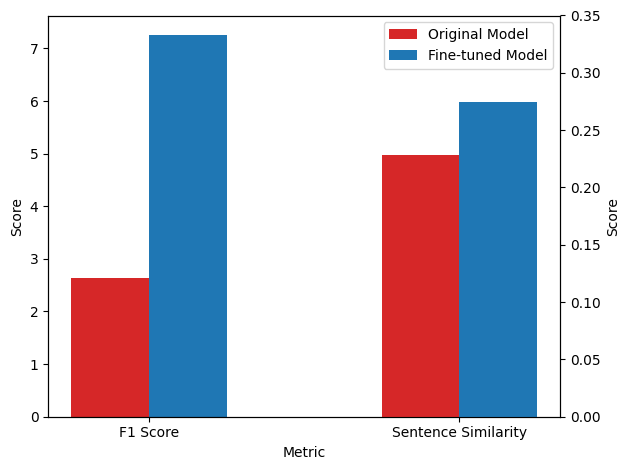

In [52]:
bar_width = 0.25
br1 = np.arange(2)
br2 = [x + bar_width for x in br1]

f1_scores = [f1_original, f1_tuned]
sentence_sim_scores = [sentence_sim_original, sentence_sim_tuned]

fig, ax1 = plt.subplots()

colors = ["tab:red", "tab:blue"]

# F1 Metric
ax1.set_xlabel('Metric')
ax1.set_ylabel('Score')
ax1.bar([0], f1_scores[0], color=colors[0], width=bar_width, label="Original Model")
ax1.bar([0.25], f1_scores[1], color=colors[1], width=bar_width, label="Fine-tuned Model")
ax1.tick_params(axis='y')
ax1.legend()

# x axis labels
ax1.set_xticks([0.125, 1.125])
ax1.set_xticklabels(['F1 Score', 'Sentence Similarity'])

# second axis that shares the same x-axis for the second metric
ax2 = ax1.twinx()

# Sentence Similarity Metric
ax2.set_ylabel('Score')
ax2.bar([1], sentence_sim_scores[0], color=colors[0], width=bar_width)
ax2.bar([1.25], sentence_sim_scores[1], color=colors[1], width=bar_width)
ax2.tick_params(axis='y')
ax2.set_ylim([0,0.35])

fig.tight_layout()
plt.show()

Both metrics show an improvement in the fine-tuned model's performance over its performance before the fine-tuning. The difference in F1 score is larger, relatively speaking, although both are very low due to the low likelihood of open-form answers containing the same tokens.

#### Plot ROUGE Score

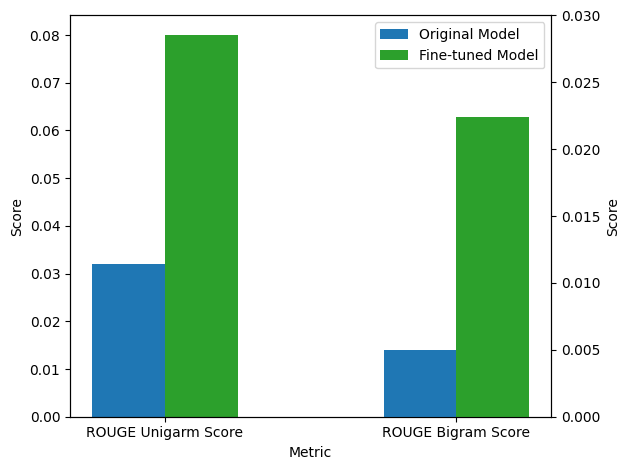

In [76]:
bar_width = 0.25
br1 = np.arange(2)
br2 = [x + bar_width for x in br1]

rouge1_scores = [rouge1_original, rouge1_tuned]
rouge2_scores = [rouge2_original, rouge2_tuned]

fig, ax1 = plt.subplots()

colors = ["tab:blue", "tab:green"]

# F1 Metric
ax1.set_xlabel('Metric')
ax1.set_ylabel('Score')
ax1.bar([0], rouge1_scores[0], color=colors[0], width=bar_width, label="Original Model")
ax1.bar([0.25], rouge1_scores[1], color=colors[1], width=bar_width, label="Fine-tuned Model")
ax1.tick_params(axis='y')
ax1.legend()

# x axis labels
ax1.set_xticks([0.125, 1.125])
ax1.set_xticklabels(['ROUGE Unigarm Score', 'ROUGE Bigram Score'])

# second axis that shares the same x-axis for the second metric
ax2 = ax1.twinx()

# Sentence Similarity Metric
ax2.set_ylabel('Score')
ax2.bar([1], rouge2_scores[0], color=colors[0], width=bar_width)
ax2.bar([1.25], rouge2_scores[1], color=colors[1], width=bar_width)
ax2.tick_params(axis='y')
ax2.set_ylim([0,0.03])

fig.tight_layout()
plt.show()

Both metrics show a significant improvement in the fine-tuned model. This indicates a higher overlap between the fine-tuned model's outputs and the correct answers to the posed questions.